In [3]:
import pandas as pd
import numpy as np


In [4]:
dataset = pd.read_excel('Retail.xlsx')
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
print(dataset.isnull().sum)

<bound method DataFrame.sum of         InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  \
0           False      False        False     False        False      False   
1           False      False        False     False        False      False   
2           False      False        False     False        False      False   
3           False      False        False     False        False      False   
4           False      False        False     False        False      False   
...           ...        ...          ...       ...          ...        ...   
541904      False      False        False     False        False      False   
541905      False      False        False     False        False      False   
541906      False      False        False     False        False      False   
541907      False      False        False     False        False      False   
541908      False      False        False     False        False      False   

        CustomerID  

In [6]:
print(dataset.duplicated().sum())

5268


In [7]:
print(dataset.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


In [8]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [9]:
dataset = dataset.drop_duplicates()

In [10]:
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'])

<ipython-input-10-83473dc5c68b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'])


In [11]:
import datetime as dt

reference_date = dataset['InvoiceDate'].max() + dt.timedelta(days=1)

print('Reference Date:', reference_date)

Reference Date: 2011-12-10 12:50:00


In [12]:

recency = dataset.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (reference_date - recency['InvoiceDate']).dt.days
recency = recency[['CustomerID', 'Recency']]


In [13]:
frequency = dataset.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

In [14]:
dataset.loc[:, 'TotalAmount'] = dataset['Quantity'] * dataset['UnitPrice']
monetary = dataset.groupby('CustomerID')['TotalAmount'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

In [15]:
rfm = recency.merge(frequency, on='CustomerID', how='inner')
print(rfm.head())

   CustomerID  Recency  Frequency
0     12346.0      326          2
1     12347.0        2          7
2     12348.0       75          4
3     12349.0       19          1
4     12350.0      310          1


In [16]:
print(rfm.describe())

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rfm[['Recency', 'Frequency']] = scaler.fit_transform(rfm[['Recency', 'Frequency']])
print(rfm.head())

         CustomerID      Recency    Frequency
count   4372.000000  4372.000000  4372.000000
mean   15299.677722    92.047118     5.075480
std     1722.390705   100.765435     9.338754
min    12346.000000     1.000000     1.000000
25%    13812.750000    17.000000     1.000000
50%    15300.500000    50.000000     3.000000
75%    16778.250000   143.000000     5.000000
max    18287.000000   374.000000   248.000000
   CustomerID   Recency  Frequency
0     12346.0  0.871314   0.004049
1     12347.0  0.002681   0.024291
2     12348.0  0.198391   0.012146
3     12349.0  0.048257   0.000000
4     12350.0  0.828418   0.000000


In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

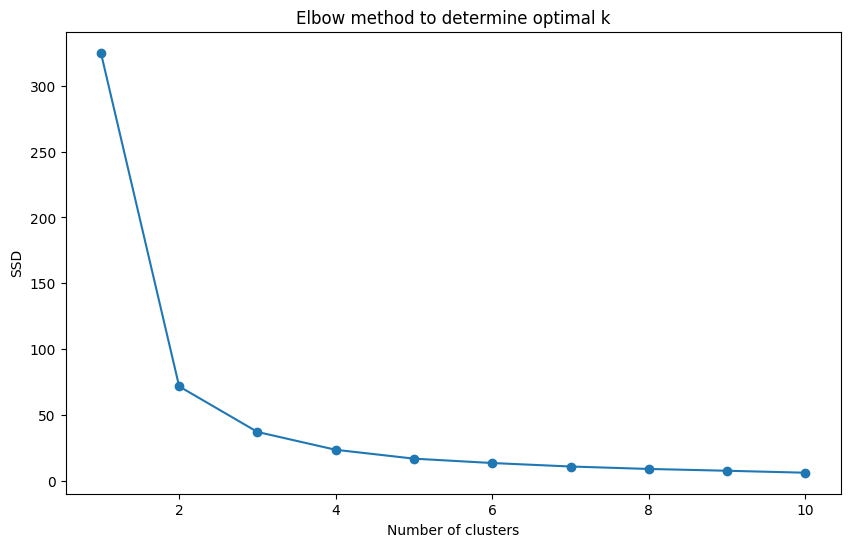

In [19]:
ssd = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm[['Recency', 'Frequency']])
    ssd.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,11),ssd,marker='o')
plt.title('Elbow method to determine optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSD')
plt.show()

In [20]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm[['Recency', 'Frequency']])
print(rfm.head())

   CustomerID   Recency  Frequency  Cluster
0     12346.0  0.871314   0.004049        1
1     12347.0  0.002681   0.024291        0
2     12348.0  0.198391   0.012146        2
3     12349.0  0.048257   0.000000        0
4     12350.0  0.828418   0.000000        1


In [21]:
centroids = rfm.groupby('Cluster').mean()
print(centroids)

           CustomerID   Recency  Frequency
Cluster                                   
0        15303.740844  0.046643   0.027238
1        15292.014925  0.818670   0.002168
2        15224.237016  0.208617   0.008575
3        15421.024194  0.494902   0.005067


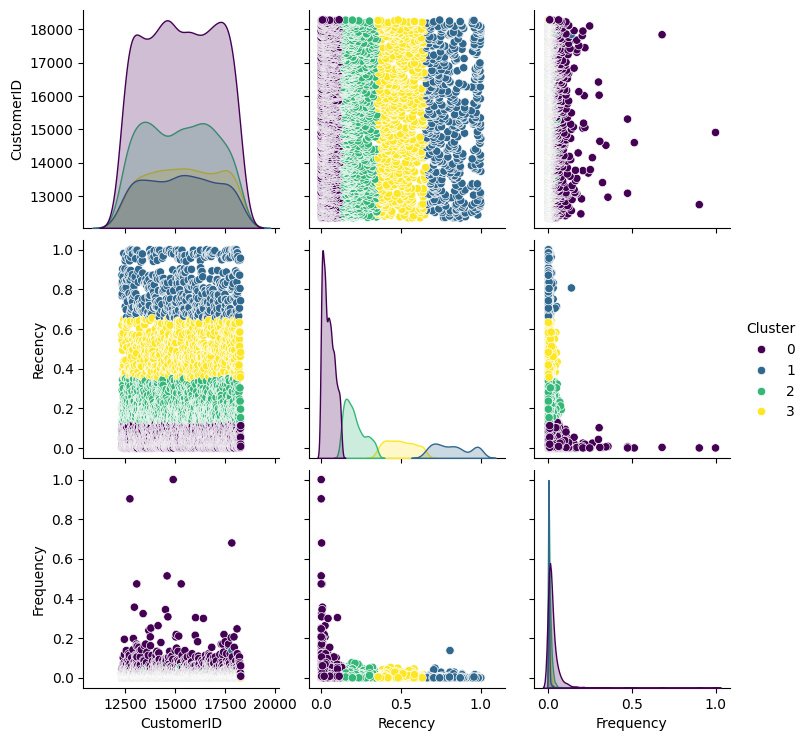

In [22]:
sns.pairplot(rfm,hue='Cluster', palette = 'viridis', diag_kind='kde')
plt.show()

In [23]:
rfm.to_excel('rfm_output.xlsx', index=False)